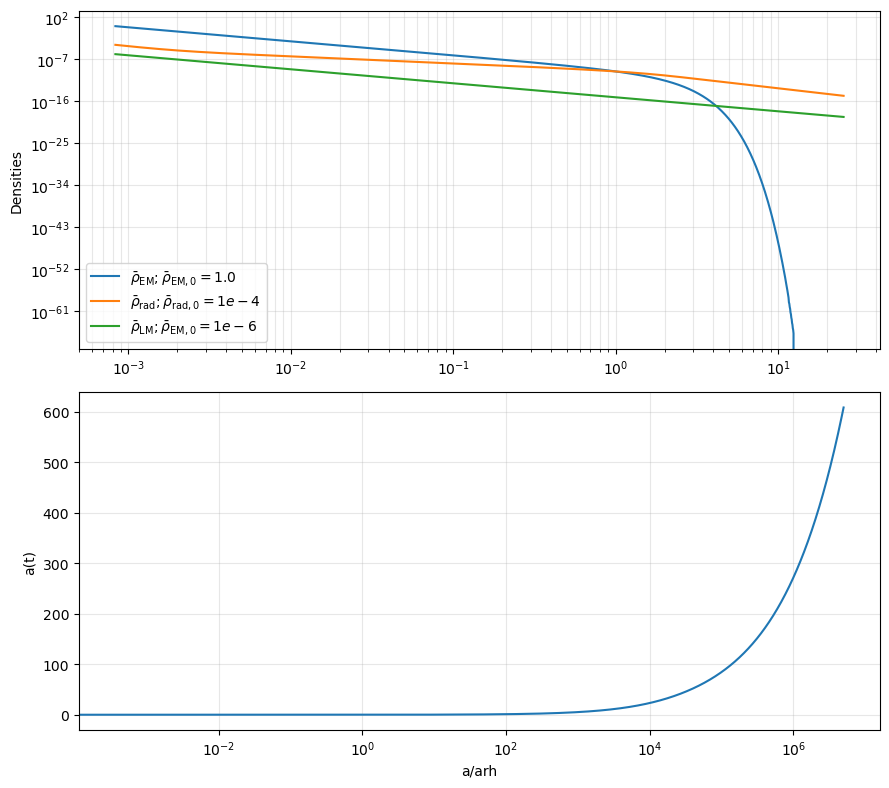

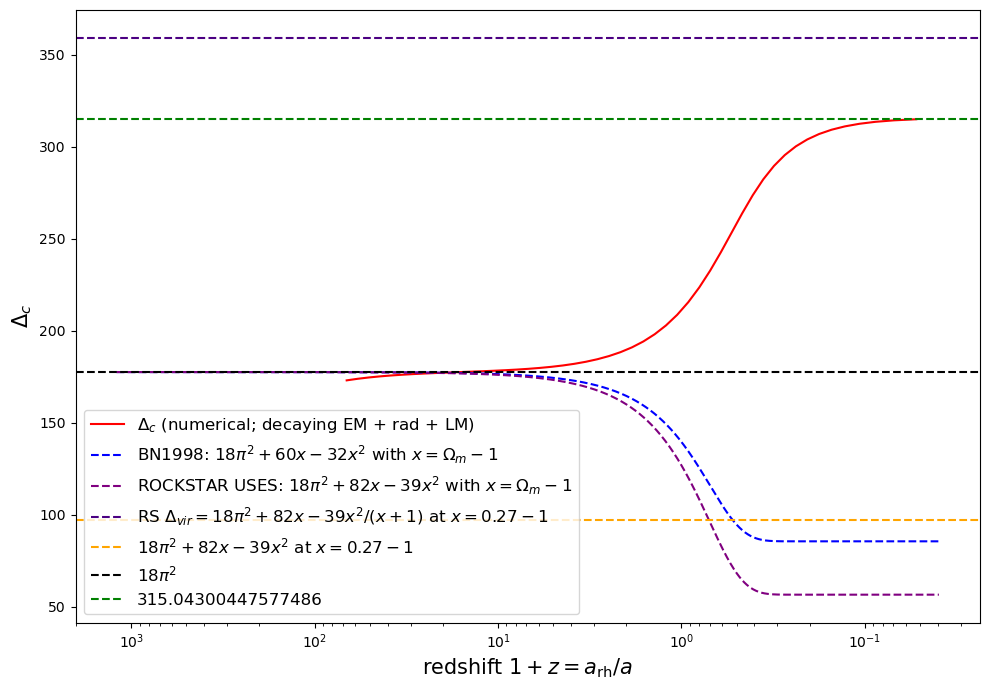

In [4]:
import numpy as np
from math import sqrt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import brentq
import matplotlib.pyplot as plt

# Quick helper function:
def crossings_from_solution(sol, n_scan=2000):
    """
    Find times where the EM background density equals the radiation density
    using an ODE solution. This is used to estimate reheating time 
    (rho_em(t) - rho_rad(t) = 0), because other methods 
    I tried sometimes gave me the wrong value or found the wrong minimum due to super
    small values reached by the em and rad. it is a (perhaps unneccessarily) more
    complicated way to find it to ensure that it is the correct reheating value everytime. lol.
    Idea:
    - Sample logarithmically in time across the solution domain.
    - Detect sign changes in g(t) = rho_em - rho_rad.
    - Refine each bracketed sign change to a root using Brent's method.
    Arguments:
    sol: scipy.integrate.OdeResult
        Result from solve_ivp(..., dense_output=True). !!!! Assumes:
          sol.sol(t)[1] is rho_em(t)
          sol.sol(t)[2] is rho_rad(t)!!!!
    n_scan: mumber of log-spaced samples for initial bracketing.
    Returns: Array of root times
    """
    tmin, tmax = sol.t[0], sol.t[-1]

    # Log-spaced grid in time:
    # Add a tiny offset to avoid log10(0) if tmin is exactly 0
    ts = np.logspace(np.log10(tmin + 1e-30), np.log10(tmax), n_scan)

    # the two components we want to compare
    em_s  = sol.sol(ts)[1]
    rad_s = sol.sol(ts)[2]
    g = em_s - rad_s
    #roots are where g = 0.

    roots = []
    for i in range(len(ts) - 1):
        # Skip intervals where the interpolated values are invalid.
        if np.isnan(g[i]) or np.isnan(g[i+1]):
            continue

        # Save where we land right on zero.
        if g[i] == 0.0:
            roots.append(ts[i])
            continue
        # Look for sign changes, which bracket a root.
        if g[i] * g[i+1] < 0.0:
            # Refine the bracket [ts[i], ts[i+1]] using Brent's method.
            # We re-evaluate the dense solution inside brentq.
            r = brentq(lambda tt: sol.sol(tt)[1] - sol.sol(tt)[2], ts[i], ts[i+1], maxiter=100)
            roots.append(r)
    return np.array(roots)


# Now onto the background density solutions!
G = 1.0
TAU = 1.0e4 #lifetime


def rhs_bg(t, y):
    """
    System:
      - y = [a, rho_em, rho_rad, rho_lm]
      - H^2 = (8*pi*G/3) * (rho_em + rho_rad + rho_lm)
      - da/dt = a * H
    Note: the max(..., 0) guards are purely numerical safety to keep densities
        non-negative if the stiff solver overshoots slightly.
    Returns: [da_dt, d(rho_em)/dt, d(rho_rad)/dt, d(rho_lm)/dt]
    """
    a, rho_em, rho_rad, rho_lm = y

    # Numerical safety: ensure non-negative densities.
    rho_em  = max(rho_em,  0.0)
    rho_rad = max(rho_rad, 0.0)
    rho_lm  = max(rho_lm,  0.0)
    rho_tot = rho_em + rho_rad + rho_lm
    H2 = (8.0 * np.pi * G / 3.0) * max(rho_tot, 0.0)
    H  = sqrt(H2)

    # Diff eqns:.
    da_dt   = a * H
    dem_dt  = -rho_em / TAU - 3.0 * H * rho_em
    drad_dt = rho_em / TAU - 4.0 * H * rho_rad
    dlm_dt  = -3.0 * H * rho_lm

    return [da_dt, dem_dt, drad_dt, dlm_dt]


# Background initial conditions & integration interval
t0, tf   = 0.0, 5.0e6 
a0 = 0.02
rho_em0  = 1.0
rho_rad0 = 1.0e-4
rho_lm0  = 1.0e-6

y0_bg    = [a0, rho_em0, rho_rad0, rho_lm0]

# Integrate:
# Radau is used because the system can be stiff
sol_bg = solve_ivp(
    rhs_bg, (t0, tf), y0_bg,
    method="Radau", rtol=1e-10, atol=1e-12,
    dense_output=True, events=[stall_a])

t   = sol_bg.t
a   = sol_bg.y[0]
em  = sol_bg.y[1]
rad = sol_bg.y[2]
lm  = sol_bg.y[3]

# Derived background quantities
rho_tot = em + rad + lm
H       = np.sqrt((8.0 * np.pi * G / 3.0) * rho_tot)
rho_c   = 3.0 * H**2 / (8.0 * np.pi * G)  # critical density computed from H(t)


# Interpolators for background quantities 
a_of_t   = interp1d(t, a,   kind='cubic', bounds_error=False, fill_value='extrapolate')
H_of_t   = interp1d(t, H,   kind='cubic', bounds_error=False, fill_value='extrapolate')
em_of_t  = interp1d(t, em,  kind='cubic', bounds_error=False, fill_value='extrapolate')
rad_of_t = interp1d(t, rad, kind='cubic', bounds_error=False, fill_value='extrapolate')
lm_of_t  = interp1d(t, lm,  kind='cubic', bounds_error=False, fill_value='extrapolate')
rho_c_of_t = interp1d(t, rho_c, kind='cubic', bounds_error=False, fill_value='extrapolate')


# Get reheating value
t_cross = crossings_from_solution(sol_bg)
if len(t_cross) > 0:
    trh = t_cross[0]
    a_rh = float(a_of_t(trh))

z_bg = a_rh / a - 1.0


# Plot background cosmology densities
fig, axs = plt.subplots(2, 1, figsize=(9, 8), sharex=False)
# Densities as functions of scale factor normalized to a_rh.
axs[0].loglog(a/a_rh, em, label=r'$\bar\rho_{\rm EM}; \bar\rho_{\rm EM, 0}=1.0$')
axs[0].loglog(a/a_rh, rad, label=r'$\bar\rho_{\rm rad}; \bar\rho_{\rm rad, 0}=1e-4$')
axs[0].loglog(a/a_rh, lm, label=r'$\bar\rho_{\rm LM}; \bar\rho_{\rm EM, 0}=1e-6$')
axs[0].set_ylabel('Densities')
axs[0].legend(); axs[0].grid(True, which='both', alpha=0.3)

# Plot scale factor as well as a fn of time.
axs[1].semilogx(t, a)
axs[1].set_xlabel('a/arh'); axs[1].set_ylabel('a(t)')
axs[1].grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()


def rhs_tophat(t, y, M):
    """
     Spherical top-hat equation of motion with constant mass.
        y = [R, V]
        R = radius
        V = dR/dt
        d^2R/dt^2 = -GM/R^2
    Notes:
    - R is bounded below to avoid dividing by zero
    Returns: [dR_dt, dV_dt]
    """
    R, V = y
    R = max(R, 1e-40)
    return [V, -G * M / (R**2)]


# Choose ICs:
i0   = 1 
t_i  = t[i0]
a_i  = float(a_of_t(t_i))
H_i  = float(H_of_t(t_i))

rho_m_i = float(em_of_t(t_i) + lm_of_t(t_i))

# Initial overdensity grid to go over:
# Larger grid = better resolution but more to solve, it takes longer.
delta_grid = np.logspace(-6, -1, 80)

# Arrays to fill up:
# zvir_list: virialization redshift based on a_vir
# Delta_crit_ratio_list: rho_tophat / rho_crit at virialization
zvir_list = []
Delta_crit_ratio_list = []   # using crit density: rho_tophat / rho_crit at t_virialization


# Iterate over each possible d0:
for d0 in delta_grid:
    # Linear initial conditions for spherical overdensity:
    # R_i = a_i r_com (1 - δ/3)
    # V_i = H_i R_i (1 - δ/3)
    r_com = 1.0
    R_i = a_i * r_com * (1.0 - d0/3.0)
    V_i = H_i * R_i * (1.0 - d0/3.0)
    M = (4.0/3.0) * np.pi * (R_i**3) * rho_m_i * (1.0 + d0)

    # Define turnaround event: V = 0 while transitioning from expansion (V>0) to collapse (V<0).
    def ev_turn(tt, yy):
        return yy[1]
    ev_turn.terminal  = True   # stop integration at turnaround
    ev_turn.direction = -1     # only detect crossing from pos to neg

    # Integrate until turnaround
    sol_th = solve_ivp(
        lambda tt, yy: rhs_tophat(tt, yy, M),
        (t_i, tf), [R_i, V_i],
        method='Radau', rtol=1e-10, atol=1e-12,
        dense_output=True, events=ev_turn
    )

    if len(sol_th.t_events[0]) == 0:
        # Turnaround not reached within the integration window; skip this d0
        continue

        
    # t_vir = 2 t_turn, R_vir = R_turn / 2
    # this is an assumption; change if using different virializtaion criteria
    t_max = sol_th.t_events[0][0]
    R_max = sol_th.sol(t_max)[0]
    t_vir = 2.0 * t_max
    R_vir = 0.5 * R_max

    # Make sure the background interpolation range includes t_vir
    if not (t[0] <= t_vir <= t[-1]):
        continue

    # Densities at virialization:
    # rho_th_vir: mean density inside the top-hat sphere at R_vir
    # rho_c_vir: background critical density at t_vir
    rho_th_vir = (3.0 * M)/(4.0 * np.pi * R_vir**3)  # avg top-hat density
    rho_c_vir  = float(rho_c_of_t(t_vir))              # critical density

    a_vir = float(a_of_t(t_vir))
    z_vir = a_rh / a_vir - 1.0

    zvir_list.append(z_vir)
    Delta_crit_ratio_list.append(rho_th_vir / rho_c_vir)

zvir  = np.array(zvir_list)
Delta_crit_ratio_num = np.array(Delta_crit_ratio_list)


# Two BN1998 formulas:
Omega_m_bg = (em + lm) / (em + lm + rad)
x_bg       = Omega_m_bg - 1.0
Delta_crit_BN = 18.0 * np.pi**2 + 60.0 * x_bg - 32.0 * x_bg**2
Delta_crit_BN2 = 18*np.pi**2 + 82*x_bg - 39*x_bg**2 #ROCKSTAR uses this one

# LCDM reference numbers at Ω_m = 0.27 (so x = 0.27 - 1).
x2 = 0.27-1
Delta_crit_BN_LCDM = (18*np.pi**2 + 82*x2 - 39*x2**2)

# Convert Δ_crit to Δ_vir by dividing by Ω_m
Delta_vir_BN_LCDM = (18*np.pi**2 + 82*x2 - 39*x2**2)/(x2+1)


# Plot numerical overdensity params compared to BN1998
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(1+zvir, Delta_crit_ratio_num, color='r',
           label=r'$\Delta_{c}$ (numerical; decaying EM + rad + LM)')
ax.plot(1+z_bg, Delta_crit_BN, 'b--',
        label=r'BN1998: $18\pi^{2}+60x-32x^{2}$ with $x=\Omega_{m}-1$')
ax.plot(1+z_bg, Delta_crit_BN2, 'purple', linestyle='--',
        label=r'ROCKSTAR USES: $18\pi^{2}+82x-39x^{2}$ with $x=\Omega_{m}-1$')


# Reference: ROCKSTAR formula evaluated at Ω_m=0.27 (like they say in their paper)
ax.axhline(Delta_vir_BN_LCDM, color= 'indigo', linestyle='--',
        label=r'RS $\Delta_{vir} = 18\pi^{2}+82x-39x^{2}/(x+1)$ at $x=0.27-1$')
# Rockstar formula evaluated at Ω_m=0.27 but now it is critical overdensity instead of virial
ax.axhline(Delta_crit_BN_LCDM, color= 'orange', linestyle='--',
        label=r'$18\pi^{2}+82x-39x^{2}$ at $x=0.27-1$')
# EdS reference
ax.axhline(18.0 * np.pi**2, color='k', linestyle='--',
           label=r'$18\pi^{2}$')
ax.set_xscale('log')
ax.invert_xaxis()
ax.set_xlabel(r'redshift $1+z = a_{\rm rh}/a$', fontsize=15)
ax.set_ylabel(r'$\Delta_{c}$', fontsize=15)
# max value reached by numerical overdensity estimaiton
ax.axhline(np.max(Delta_crit_ratio_num), color='g', linestyle='--',
           label=f'{np.max(Delta_crit_ratio_num)}')
ax.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()